# Student Performance Predictor

## Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

### Importing Dataset

In [2]:
df = pd.read_csv('../data/math_subject_grade_prediction.csv')

### Feature Engineering

In [3]:
df['Past_Performance_Grade'] = (df.G1 + df.G2) / 2
df['Parents_Education'] = (df.Medu + df.Fedu) / 2
df['Alcohol_Consumption'] = (df.Walc + df.Dalc)

In [4]:
df.drop(['school', 'sex','G1', 'G2', 'Medu', 'Fedu', 'Dalc', 'Walc', 'guardian', 'reason'], 
        axis=1, inplace=True)

In [5]:
df.columns=['Age', 'Locality', 'Family_Size', 'Parents_Cohab_Status', 'Mother_Job',
            'Father_Job', 'Home_to_School_Travel_Time', 'Weekly_Study_Time', 'Past_Class_Failure_Count', 
            'School_Support', 'Family_Support', 'Extra_Paid_Classes', 'Extra_Curr_Activities', 
            'Attended_Kindergarten', 'Higher_Edu', 'Internet', 'Dating', 'Family_Relationship', 
            'Freetime_After_School', 'Goes_Out', 'Current_Health_Status', 'School_Absences', 
            'Final_Grade', 'Past_Grade_Record', 'Parents_Education', 'Alcohol_Consumption']

### Feature Encoding

In [6]:
onehot_cols = ['Father_Job', 'Mother_Job']
ord_enc_cols = ['School_Support', 'Family_Support', 'Higher_Edu', 'Extra_Paid_Classes', 'Locality', 
                'Family_Size', 'Parents_Cohab_Status', 'Dating', 'Extra_Curr_Activities', 
                'Attended_Kindergarten', 'Internet']


In [7]:
df_cols = list(df.columns)

In [8]:
enc_cols = onehot_cols+ord_enc_cols

In [9]:
len(df_cols), len(enc_cols)

(26, 13)

In [10]:
scaler_cols = [col for col in df_cols if col not in enc_cols]

In [11]:
scaler_cols.remove('Final_Grade')

In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler # col_trnsfrmr
from sklearn.compose import ColumnTransformer


transformers = [('onehot', OneHotEncoder(sparse_output=False), onehot_cols), 
                ('ord_enc', OrdinalEncoder(), ord_enc_cols), 
                ('scaler', StandardScaler(), scaler_cols)]

col_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough', sparse_threshold=0, 
                                    n_jobs=6, verbose=True, verbose_feature_names_out=False)


In [13]:
col_transformer.set_output(transform='pandas')

ColumnTransformer(n_jobs=6, remainder='passthrough', sparse_threshold=0,
                  transformers=[('onehot', OneHotEncoder(sparse_output=False),
                                 ['Father_Job', 'Mother_Job']),
                                ('ord_enc', OrdinalEncoder(),
                                 ['School_Support', 'Family_Support',
                                  'Higher_Edu', 'Extra_Paid_Classes',
                                  'Locality', 'Family_Size',
                                  'Parents_Cohab_Status', 'Dating',
                                  'Extra_Curr_Activities',
                                  'Attended_Kindergarten', 'Internet']),
                                ('scaler', StandardScaler(),
                                 ['Age', 'Home_to_School_Travel_Time',
                                  'Weekly_Study_Time',
                                  'Past_Class_Failure_Count',
                                  'Family_Relationship',
                                  'Freetime_After_School', 'Goes_Out',
                                  'Current_Health_Status', 'School_Absences',
                                  'Past_Grade_Record', 'Parents_Education',
                                  'Alcohol_Consumption'])],
                  verbose=True, verbose_feature_names_out=False)

In [14]:
X = df.drop(['Final_Grade'], axis=1)
Y = df['Final_Grade']

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
x_train_new = col_transformer.fit_transform(x_train)

In [68]:
# from joblib import dump
# with open('../models/col_transformer_fitted.joblib', 'wb') as f:
#     dump(col_transformer, f)

## Model Training

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

In [45]:
steps=[('select_k_best', SelectKBest(score_func=mutual_info_regression)), 
       ('model', RandomForestRegressor(random_state=42))]
pipeline = Pipeline(steps=steps)


param_grid = [
    {'select_k_best__k': [5, 10, 15], 
     'model': [RandomForestRegressor(random_state=42)],
     'model__n_estimators': [100, 300, 500, 700], 
     'model__max_features': [0.5, 0.75, 1.0], 
     'model__max_depth': [None, 25, 50, 75], 
     'model__oob_score': [True, False]
    }
]


In [46]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           n_jobs=6, refit=True, cv=5, verbose=2, 
                           return_train_score=True)

In [47]:
grid_search.fit(x_train_new, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select_k_best',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x000001B8543F15A0>)),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=6,
             param_grid=[{'model': [RandomForestRegressor(random_state=42)],
                          'model__max_depth': [None, 25, 50, 75],
                          'model__max_features': [0.5, 0.75, 1.0],
                          'model__n_estimators': [100, 300, 500, 700],
                          'model__oob_score': [True, False],
                          'select_k_best__k': [5, 10, 15]}],
             return_train_score=True, verbose=2)

In [48]:
grid_search.best_estimator_

Pipeline(steps=[('select_k_best',
                 SelectKBest(k=15,
                             score_func=<function mutual_info_regression at 0x000001B8543F15A0>)),
                ('model',
                 RandomForestRegressor(max_features=0.75, n_estimators=300,
                                       oob_score=True, random_state=42))])

In [70]:
# from joblib import dump
# with open('../models/grid_search_best_estimator.joblib', 'wb') as f:
#     dump(grid_search.best_estimator_, f)

In [50]:
selector = grid_search.best_estimator_.named_steps['select_k_best']

In [51]:
support_masks = selector.get_support()
best_features = x_train_new.columns[support_masks].tolist()

In [52]:
best_features

['Mother_Job_health',
 'Mother_Job_other',
 'Mother_Job_teacher',
 'School_Support',
 'Family_Support',
 'Family_Size',
 'Dating',
 'Attended_Kindergarten',
 'Home_to_School_Travel_Time',
 'Weekly_Study_Time',
 'Past_Class_Failure_Count',
 'Current_Health_Status',
 'School_Absences',
 'Past_Grade_Record',
 'Alcohol_Consumption']

In [73]:
# from joblib import dump
# with open('../models/grid_search_best_estimator_features.joblib', 'wb') as f:
#     dump(best_features, f)

In [54]:
grid_search.best_params_

{'model': RandomForestRegressor(random_state=42),
 'model__max_depth': None,
 'model__max_features': 0.75,
 'model__n_estimators': 300,
 'model__oob_score': True,
 'select_k_best__k': 15}

In [76]:
# from joblib import dump
# with open('../reports/grid_search_best_params.joblib', 'wb') as f:
#     dump(grid_search.best_params_, f)

In [56]:
grid_search.best_score_

np.float64(0.8863698500657671)

In [79]:
# from joblib import dump
# with open('../reports/grid_search_best_score.joblib', 'wb') as f:
#     dump(grid_search.best_score_, f)

## Model Testing

In [86]:
lr = LinearRegression()
svr = LinearSVR()
rfr = RandomForestRegressor(random_state=42)
rfr_best_params = RandomForestRegressor(n_estimators=300, max_depth=None, max_features=0.75, 
                                       oob_score=True, n_jobs=-1, random_state=42) 

In [87]:
lr.fit(x_train_new, y_train)
svr.fit(x_train_new, y_train)
rfr.fit(x_train_new, y_train)
rfr_best_params.fit(x_train_new[best_features], y_train)

RandomForestRegressor(max_features=0.75, n_estimators=300, n_jobs=-1,
                      oob_score=True, random_state=42)

In [88]:
x_test_new = col_transformer.transform(x_test)

In [89]:
y_preds_lr = lr.predict(x_test_new)
y_preds_svr = svr.predict(x_test_new)
y_preds_rfr = rfr.predict(x_test_new)
y_preds_be = rfr_best_params.predict(x_test_new[best_features])

In [90]:
from sklearn.metrics import r2_score, mean_absolute_error

In [91]:
r2_score(y_test, y_preds_lr), r2_score(y_test, y_preds_svr)

(0.7061371726650263, 0.7465229846193553)

In [92]:
r2_score(y_test, y_preds_rfr), r2_score(y_test, y_preds_be)

(0.8326918872878443, 0.779415436275991)

In [93]:
mean_absolute_error(y_test, y_preds_lr), mean_absolute_error(y_test, y_preds_svr)

(1.801165555153923, 1.4663679863804195)

In [95]:
mean_absolute_error(y_test, y_preds_rfr), mean_absolute_error(y_test, y_preds_be)

(1.147594936708861, 1.3109282700421938)

### Plotting the predictions vs original target values

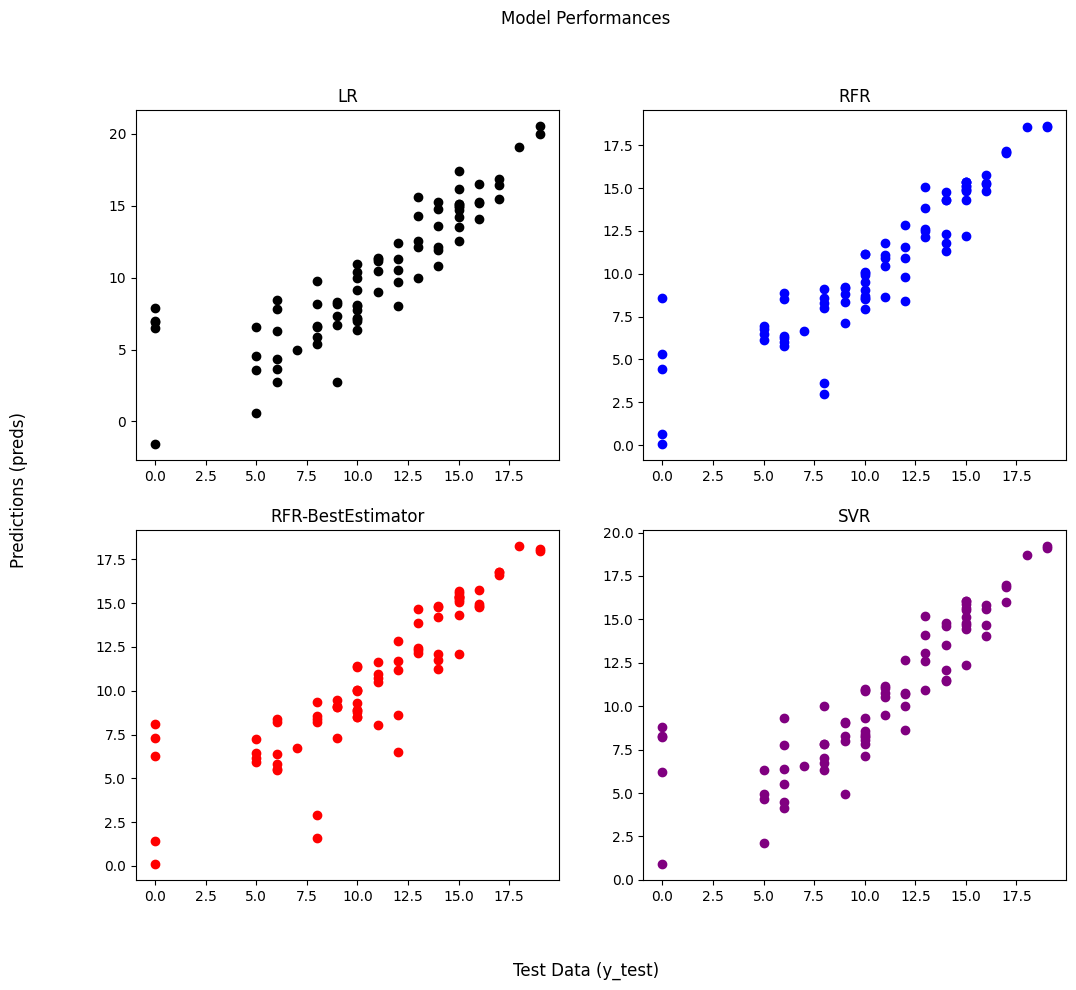

In [99]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Model Performances')
fig.supxlabel('Test Data (y_test)')
fig.supylabel('Predictions (preds)')

axs[0][0].scatter(y_test, y_preds_lr, color='black')
axs[0][0].set_title('LR')
axs[0][1].scatter(y_test, y_preds_rfr, color='blue')
axs[0][1].set_title('RFR')
axs[1][0].scatter(y_test, y_preds_be, color='red')
axs[1][0].set_title('RFR-BestEstimator')
axs[1][1].scatter(y_test, y_preds_svr, color='purple')
axs[1][1].set_title('SVR')

plt.show()
# plt.savefig('../reports/Models_Performance.png')

In [98]:
# from joblib import dump
# with open('../models/rfr_fitted_with_best_params.joblib', 'wb') as f:
#     dump(rfr_best_params, f)